In [1]:
# Quantum Walk in 1-Dimeintion 
# <Hadamard Walk>
# IBM Quantum

#------ import
#--- qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

# IBMQ
from qiskit_ibm_runtime import QiskitRuntimeService

# passManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#--- math & graph
import numpy  as np
import pandas as pd
import dataframe_image as dfi
import matplotlib.pyplot as plt
import IPython.display as display
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.font_manager import FontProperties

#--- os (file handle)
import os
import glob

In [2]:

numBitPosition = 4  # qubit for positions -> 4^2 = 16 position
numBitCoin     = 1  # qubit for states

# Simulator settings
shots = 1200
#sampler = StatevectorSampler()

# Number of executions (steps)
num_executions = 12

# Define the number of rows per dataframe image(max 23step)
rows_per_chunk = 23

# Function to create the quantum walk circuit with a given number of steps
def create_quantum_walk_circuit(qwStep):
    qc = QuantumCircuit(numBitPosition + numBitCoin, numBitPosition)
    
    # Initial state (position / center of the histgram)
    # DEC(7), bin(0111), qiskitBitOrder(1110)  
    qc.x(1)
    qc.x(2)
    qc.x(3)

    # Initial state (coin)
    qc.h(numBitPosition)
    qc.s(numBitPosition)
    qc.barrier()
    
    # Quantum walk steps
    for i in range(qwStep):
        # Coin flip
        qc.h(4)
        # Shift <adder>
        qc.x(4)
        qc.cx(4, 3)
        qc.ccx(4, 3, 2)
        qc.mcx([4, 3, 2], 1)
        qc.mcx([4, 3, 2, 1], 0)
        # Shift <subtractor>
        qc.x(4)
        qc.mcx([4, 3, 2, 1], 0)
        qc.mcx([4, 3, 2], 1)
        qc.ccx(4, 3, 2)
        qc.cx(4, 3)
    
    # Measurement
    qc.barrier()
    qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
    return qc

# Function to fill counts with zero counts
def fill_counts_with_zeros(counts, numBitPosition):
    def decimal_to_base(n, base):
        return format(n, f'{base}')
    
    bitBase = numBitPosition
    base = f'0{bitBase}b'
    
    for i in range(2 ** numBitPosition):
        binary_number = decimal_to_base(i, base)
        if binary_number not in counts:
            counts[binary_number] = 0
    return counts

# Log of results
results_log = []

for steps in range(num_executions):
    qc = create_quantum_walk_circuit(steps)
    
    # IBM Quantum : backend
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)

    #---passManager
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circ = pm.run(qc)

    # IBM Quantum : JOB(1)
    sampler = Sampler(backend)
    job = sampler.run([isa_circ], shots=shots)

    # job id
    job_id = job.job_id()
    # job info
    print(f'#--- step -> {steps}')
    print(f'backend -> {backend}')
    print("job id:", job_id)
    print(f'The number of qubits used -> {numBitPosition + numBitCoin}') 
    print(f'The depth of the quantum circuit -> {qc.depth()}') 

    #--results
    result = job.result()

    # Access result data for PUB 0
    data_pub = result[0].data
    
    # Get counts for the classical register "meas"
    counts = data_pub.c.get_counts()
    
    # Fill counts with zero counts for missing bitstrings
    counts = fill_counts_with_zeros(counts, numBitPosition)
    
    results_log.append(counts)

# Convert log to DataFrame
df = pd.DataFrame(results_log).fillna(0).astype(int)

# Insert col
df.insert(0, 'bin(qiskit)', [f'step:{i}' for i in range(num_executions)])

# insert row(decimal)
header_list = df.columns.tolist()

def is_binary_string(s):
    return all(c in '01' for c in s)

# Convert qiskit bit order to reverse order
def reverse_and_convert(header_list):
    converted_list = []

    for item in header_list:
        if not is_binary_string(item):
            if item == 'bin(qiskit)' :
                item = 'dec'
            converted_list.append(item)
            continue
        reversed_item = item[::-1]
        decimal_value = int(reversed_item, 2)
        converted_list.append(decimal_value)
    return converted_list

converted_list = reverse_and_convert(header_list)
new_df = pd.DataFrame([converted_list], columns=df.columns)
df = pd.concat([new_df, df], ignore_index=True)

# sort dec
sorted_columns = ['bin(qiskit)'] + df.iloc[0, 1:].sort_values().index.tolist()
df = df[sorted_columns]

# Save DataFrame to CSV file
df.to_csv('./images/qwh/quantum-walk-hadamard-frequency_IBMQ.csv', index=False)

#--- step -> 0
backend -> <IBMBackend('ibm_sherbrooke')>
job id: cvy06zbfd8tg008xd2bg
The number of qubits used -> 5
The depth of the quantum circuit -> 3
#--- step -> 1
backend -> <IBMBackend('ibm_sherbrooke')>
job id: cvy118n5e7xg008tyq00
The number of qubits used -> 5
The depth of the quantum circuit -> 14
#--- step -> 2
backend -> <IBMBackend('ibm_sherbrooke')>
job id: cvy12bs3vst0008zf4vg
The number of qubits used -> 5
The depth of the quantum circuit -> 25
#--- step -> 3
backend -> <IBMBackend('ibm_sherbrooke')>
job id: cvy138nh0nm00088d5zg
The number of qubits used -> 5
The depth of the quantum circuit -> 36
#--- step -> 4
backend -> <IBMBackend('ibm_sherbrooke')>
job id: cvy1489wqn10008w57q0
The number of qubits used -> 5
The depth of the quantum circuit -> 47
#--- step -> 5
backend -> <IBMBackend('ibm_sherbrooke')>
job id: cvy157mwqn10008w57vg
The number of qubits used -> 5
The depth of the quantum circuit -> 58
#--- step -> 6
backend -> <IBMBackend('ibm_sherbrooke')>
job id: 

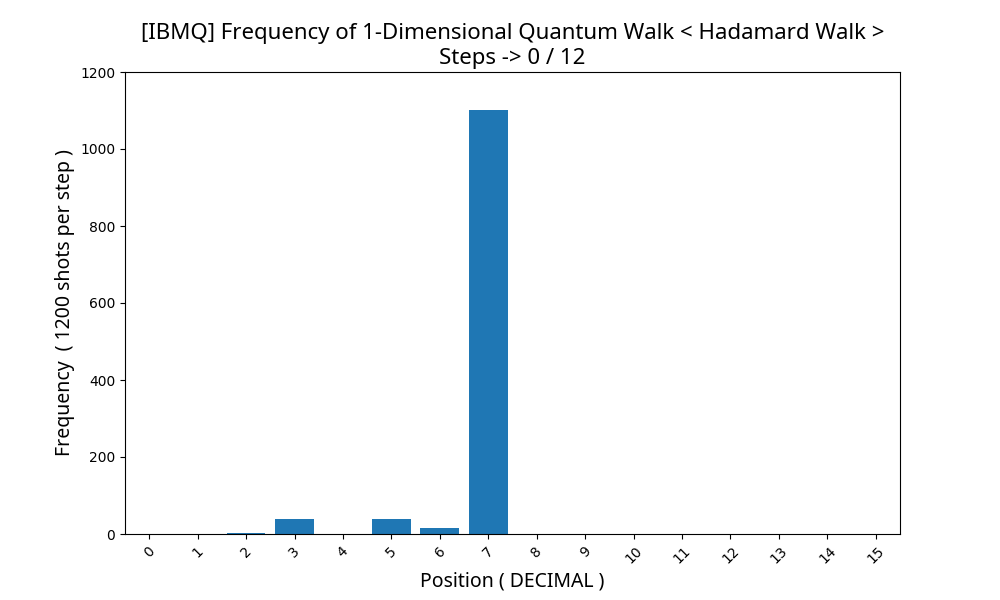

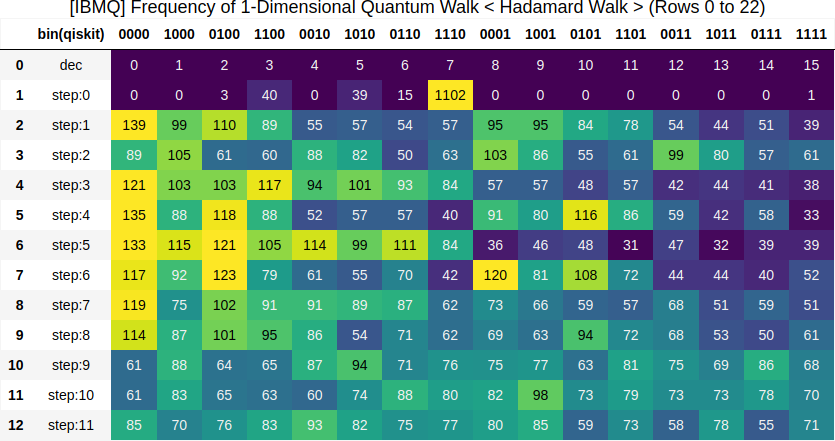

In [3]:
#------ Draw EveryThing
#--- display histogram
def create_histogram_video_from_df(df, output_file, num_executions, shots):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set font properties
    font_path = '/usr/share/fonts/truetype/NotoSans-Regular.ttf'
    font_prop = FontProperties(fname=font_path)

    def update_hist(num):
        ax.clear()
        data = df.iloc[num + 1, 1:]  
        ax.bar(data.index, data.values)
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels(df.iloc[0, 1:].sort_values().values.tolist(), rotation=45)
        ax.set_title(f'[IBMQ] Frequency of 1-Dimensional Quantum Walk < Hadamard Walk >\nSteps -> {num} / {num_executions }', fontproperties=font_prop, fontsize=16)
        ax.set_xlabel('Position ( DECIMAL )', fontproperties=font_prop, fontsize=14) 
        ax.set_ylabel(f'Frequency  ( {shots} shots per step )', fontproperties=font_prop, fontsize=14) 
        ax.set_xlim(-0.5, len(data) - 0.5)  
        ax.set_ylim(0, shots)

    ani = FuncAnimation(fig, update_hist, frames=num_executions, repeat=False)
    ani.save(output_file, writer=PillowWriter(fps=2))

output_file_final_image="./images/qwh/quantum-walk-hadamard-histogram_IBMQ.png"
create_histogram_video_from_df(df, output_file_final_image, num_executions, shots)
plt.close()
with open(output_file_final_image, 'rb') as f:
    display.display(display.Image(data=f.read(), format='png'))

# Load the CSV file into a DataFrame
df = pd.read_csv('./images/qwh/quantum-walk-hadamard-frequency_IBMQ.csv')

#--- display dataframe
# del old pic
image_dir = './images/qwh/'
image_files = glob.glob(os.path.join(image_dir, 'quantum_walk_hadamard_frequency_*_IBMQ.png'))
for image_file in image_files:
    os.remove(image_file)
    
# Split the DataFrame into chunks of var:rows_per_chunk rows each and save each chunk as a separate PNG file
for i in range(0, len(df), rows_per_chunk):
    chunk = df.iloc[i:i + rows_per_chunk]
    styled_chunk = chunk.style.set_properties(**{'text-align': 'center'}).set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center')]}]
    ).set_caption(f'[IBMQ] Frequency of 1-Dimensional Quantum Walk < Hadamard Walk > (Rows {i} to {i + rows_per_chunk - 1})').set_table_styles(
        [{'selector': 'caption', 'props': [('font-size', '18px'), ('text-align', 'center')]}]
    #).background_gradient(cmap='viridis')
    ).background_gradient(cmap='viridis', vmin=30, vmax=120)  # Colour scale for the IBMQ
    
    # Save the styled chunk as a PNG file
    dfi.export(styled_chunk, f'./images/qwh/quantum_walk_hadamard_frequency_{i // rows_per_chunk + 1}_IBMQ.png')

# show dataframe
new_image_files = sorted([f for f in os.listdir(image_dir) if f.startswith('quantum_walk_hadamard_frequency_') and f.endswith('IBMQ.png')])
for new_image_file in new_image_files:
    new_image_file = image_dir + new_image_file
    with open(new_image_file, 'rb') as f:
        display.display(display.Image(data=f.read(), format='png'))

In [4]:
import qiskit
qiskit.__version__

'1.1.0'

In [5]:
print(f'steps -> {steps + 1}')
print(f'The number of qubits used -> {numBitPosition + numBitCoin}') 
print(f'The depth of the quantum circuit -> {qc.depth()}') 

steps -> 12
The number of qubits used -> 5
The depth of the quantum circuit -> 124
